# This notebook checks the assumptions of the 6 data simulations.

### For each simulation, looks at samples 1 and 2
### For each sample, looks at 5 randomly chosen features (of the 20 generated).
### Results are for datasets with training set size of 300,000 and test set size of 100,000.

#### Alene Rhea, May 10, 2021

In [1]:
import pandas as pd
import pathlib, os, pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import random

In [2]:
base_repo_dir = pathlib.Path(os.getcwd())

# Set random state
random.seed(42)

# Set number of samples and number of features to test
# n_samps = 2
n_xfeats = 5

# Look specifically at samples 1 and 2 rather then randomly choosing
# (Implemented this way bc only have these samples saved on local)
samps = [1,2]

# Function to get y0 and y1
def get_potential_outcomes(df):
    
    # Initialize y0 and y1
    df['y0'] = np.nan
    df['y1'] = np.nan
    
    # Get observed outcomes
    df.loc[df.treatment==0, 'y0'] = df.loc[df.treatment==0, 'Y']
    df.loc[df.treatment==1, 'y1'] = df.loc[df.treatment==1, 'Y']
    
    # Get unobserved outcomes
    df.loc[df.treatment==0, 'y1'] = df.loc[df.treatment==0, 'y0'] + df.loc[df.treatment==0, 'tau']
    df.loc[df.treatment==1, 'y0'] = df.loc[df.treatment==1, 'y1'] - df.loc[df.treatment==1, 'tau']
    
    return df

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Sim A


Testing Sample 1 of Simulation A
Visually check that x4, x1, x9, x8, and x17 are approximately normal...


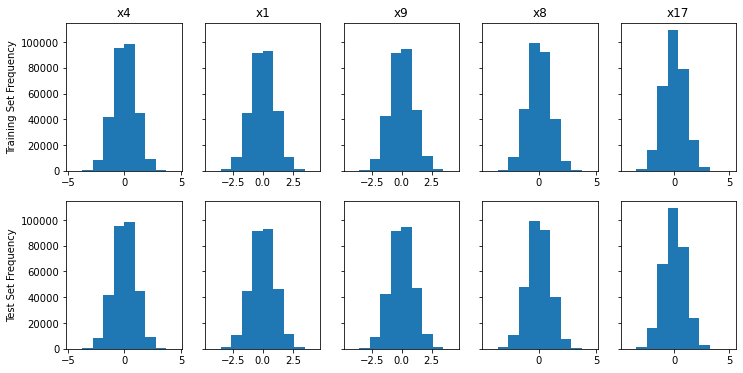

All propensity scores are 0.01? True
Proportion of training set with treatment=1 (should be close to 0.01):  0.0099
Proportion of test set with treatment=1 (should be close to 0.01):  0.0094
For training set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5):  1.0379
For test set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5):  6.3095
Wherever x2>0.1, tau=8?  True
Wherever x2<=0.1, tau=0?  True

Testing Sample 2 of Simulation A
Visually check that x5, x4, x18, x3, and x14 are approximately normal...


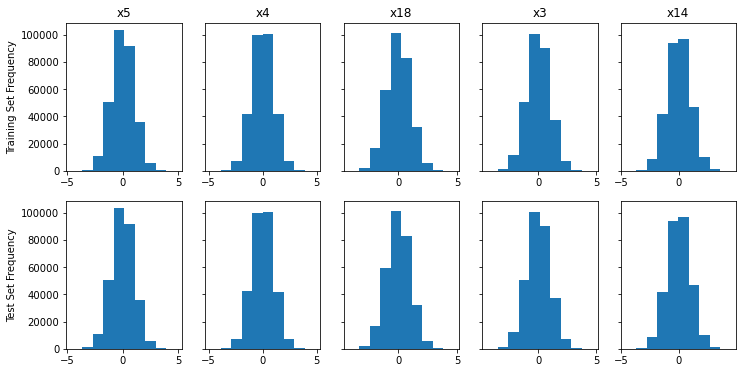

All propensity scores are 0.01? True
Proportion of training set with treatment=1 (should be close to 0.01):  0.0098
Proportion of test set with treatment=1 (should be close to 0.01):  0.0098
For training set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5):  11.8439
For test set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5):  3.0567
Wherever x2>0.1, tau=8?  True
Wherever x2<=0.1, tau=0?  True


In [4]:
# Choose 2 samples of simA to test
#Asamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation A'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simA' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simA' / 'samp{}_test.parquet'.format(samp))

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately normal...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    print('All propensity scores are 0.01?', (all(tr.pscore==.01)&all(te.pscore==.01)))
    print('Proportion of training set with treatment=1 (should be close to 0.01): ', 
          round(sum(tr.treatment==1)/len(tr), 4))
    print('Proportion of test set with treatment=1 (should be close to 0.01): ', 
          round(sum(te.treatment==1)/len(te), 4))

    # Get potential outcomes
    tr = get_potential_outcomes(tr)
    te = get_potential_outcomes(te)
    
    print('For training set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5): ',
          round(np.mean(tr[tr.x1>0.5]['y0']) - np.mean(tr[tr.x1<=0.5]['y0']), 4))
    
    print('For test set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5): ',
          round(np.mean(te[te.x1>0.5]['y0']) - np.mean(te[te.x1<=0.5]['y0']), 4))
    
    print('Wherever x2>0.1, tau=8? ', all(np.isclose(tr[tr.x2>0.1]['tau'],8)) \
                                    & all(np.isclose(te[te.x2>0.1]['tau'],8)))
    print('Wherever x2<=0.1, tau=0? ', all(np.isclose(tr[tr.x2<=0.1]['tau'],0)) \
                                    & all(np.isclose(te[te.x2<=0.1]['tau'],0)))
    

#### Difference in Mean y0 (conditioned on x1) is questionable. All other checks passed. 

## Sim B


Testing Sample 1 of Simulation B
Visually check that x2, x1, x3, x7, and x8 are approximately normal...


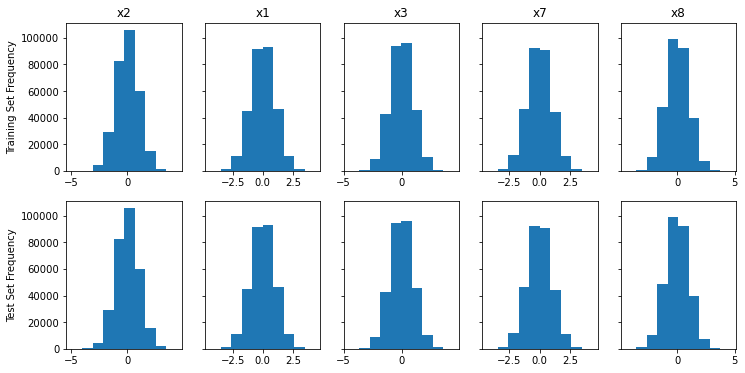

All propensity scores are 0.5? True
Proportion of training set with treatment=1 (should be close to 0.5):  0.5005
Proportion of test set with treatment=1 (should be close to 0.5):  0.498

Testing Sample 2 of Simulation B
Visually check that x17, x1, x18, x7, and x14 are approximately normal...


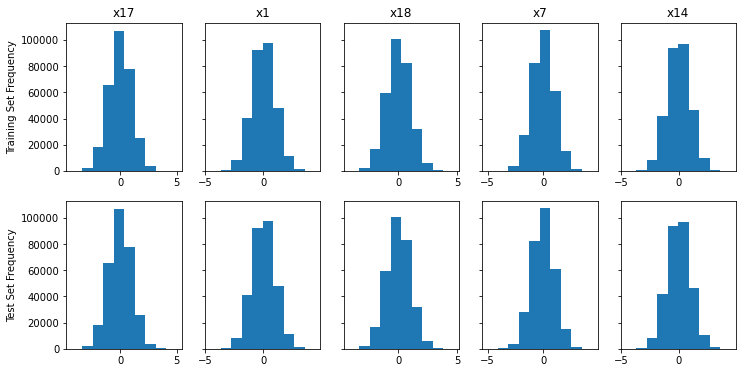

All propensity scores are 0.5? True
Proportion of training set with treatment=1 (should be close to 0.5):  0.4996
Proportion of test set with treatment=1 (should be close to 0.5):  0.5022


In [5]:
# Choose 2 samples of simB to test
# Bsamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation B'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simB' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simB' / 'samp{}_test.parquet'.format(samp))

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately normal...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    print('All propensity scores are 0.5?', (all(tr.pscore==.5)&all(te.pscore==.5)))
    print('Proportion of training set with treatment=1 (should be close to 0.5): ', 
          round(sum(tr.treatment==1)/len(tr), 4))
    print('Proportion of test set with treatment=1 (should be close to 0.5): ', 
          round(sum(te.treatment==1)/len(te), 4))


#### All checks passed.

## Sim C


Testing Sample 1 of Simulation C
Visually check that x8, x15, x9, x1, and x6 are approximately normal...


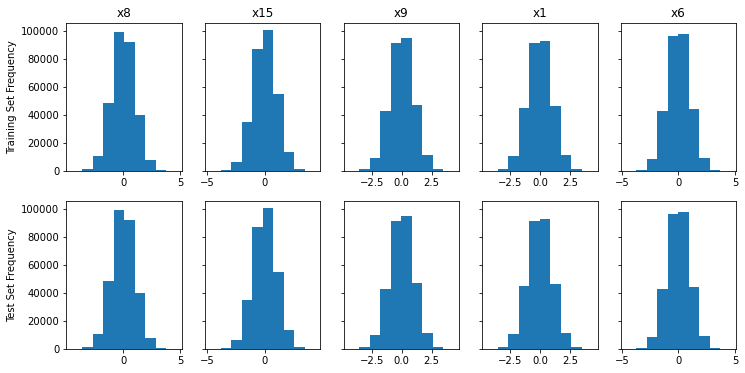

All propensity scores are 0.5? True
Proportion of training set with treatment=1 (should be close to 0.5):  0.5005
Proportion of test set with treatment=1 (should be close to 0.5):  0.498
Trainig set Y0 is product of transformed x1 and x2? False
Test set Y0 is product of transformed x1 and x2? False
Trainig set Y1 is product of transformed x1 and x2? False
Test set Y1 is product of transformed x1 and x2? False

Testing Sample 2 of Simulation C
Visually check that x14, x11, x9, x5, and x7 are approximately normal...


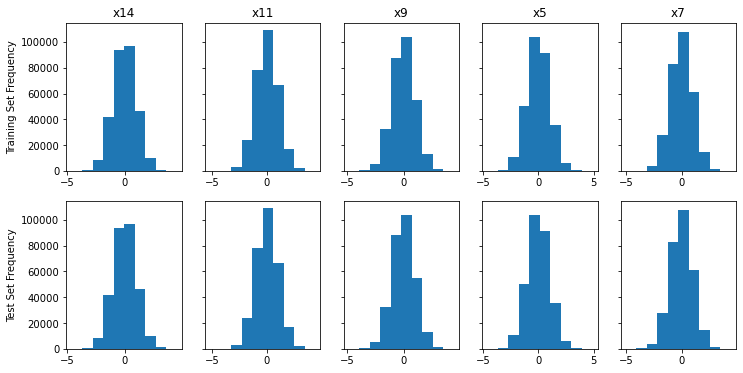

All propensity scores are 0.5? True
Proportion of training set with treatment=1 (should be close to 0.5):  0.4996
Proportion of test set with treatment=1 (should be close to 0.5):  0.5022
Trainig set Y0 is product of transformed x1 and x2? False
Test set Y0 is product of transformed x1 and x2? False
Trainig set Y1 is product of transformed x1 and x2? False
Test set Y1 is product of transformed x1 and x2? False


In [6]:
# Choose 2 samples of simC to test
# Csamps = random.sample(list(np.arange(1,31,1)), n_samps)

# Complex non-linear transformation function from SI 3
def simC_transform(x):
    x = x.values
    return 2/( 1 + np.exp(-12*(x - 0.5)))

for samp in samps:
    print('\nTesting Sample {} of Simulation C'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simC' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simC' / 'samp{}_test.parquet'.format(samp))

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately normal...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    print('All propensity scores are 0.5?', (all(tr.pscore==.5)&all(te.pscore==.5)))
    print('Proportion of training set with treatment=1 (should be close to 0.5): ', 
          round(sum(tr.treatment==1)/len(tr), 4))
    print('Proportion of test set with treatment=1 (should be close to 0.5): ', 
          round(sum(te.treatment==1)/len(te), 4))
    
    # Get potential outcomes
    tr = get_potential_outcomes(tr)
    te = get_potential_outcomes(te)
    
    print('Trainig set Y0 is product of transformed x1 and x2?', 
          all(np.isclose(tr.y0, -0.5*simC_transform(tr.x1)*simC_transform(tr.x2))))
    print('Test set Y0 is product of transformed x1 and x2?', 
          all(np.isclose(te.y0, -0.5*simC_transform(te.x1)*simC_transform(te.x2))))
    print('Trainig set Y1 is product of transformed x1 and x2?', 
          all(np.isclose(tr.y1, 0.5*simC_transform(tr.x1)*simC_transform(tr.x2))))
    print('Test set Y1 is product of transformed x1 and x2?', 
          all(np.isclose(te.y1, 0.5*simC_transform(te.x1)*simC_transform(te.x2))))


#### Failed to confirm that potential outcomes are products of non-linear transformations of x1 and x2. All other checks passed.

## Sim D


Testing Sample 1 of Simulation D
Visually check that x11, x4, x3, x13, and x19 are approximately uniform...


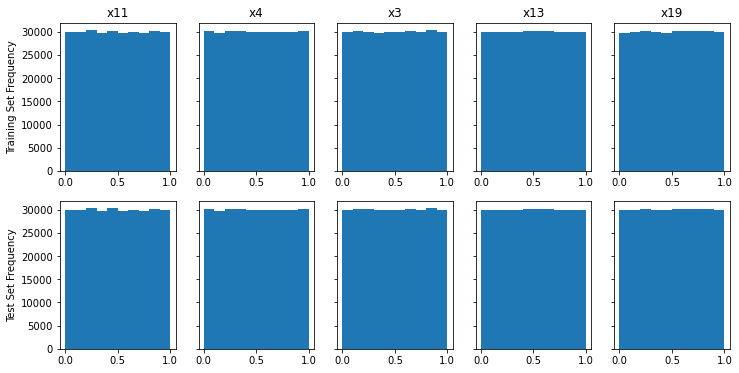

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x11,x4,x3,x13,x19
x11,1.000000,-0.002218,-0.000717,0.004884,0.002767
x4,-0.002218,1.000000,0.000519,-0.001901,0.001086
x3,-0.000717,0.000519,1.000000,0.000077,0.001438
x13,0.004884,-0.001901,0.000077,1.000000,-0.001134
x19,0.002767,0.001086,0.001438,-0.001134,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x11,x4,x3,x13,x19
x11,1.000000,-0.001442,0.004233,0.001007,0.003545
x4,-0.001442,1.000000,0.003409,-0.001485,0.001018
x3,0.004233,0.003409,1.000000,0.004026,-0.005855
x13,0.001007,-0.001485,0.004026,1.000000,-0.000185
x19,0.003545,0.001018,-0.005855,-0.000185,1.000000


Y0 = 2*x1-1?  False
All tau are 0? True

Testing Sample 2 of Simulation D
Visually check that x12, x20, x9, x2, and x15 are approximately uniform...


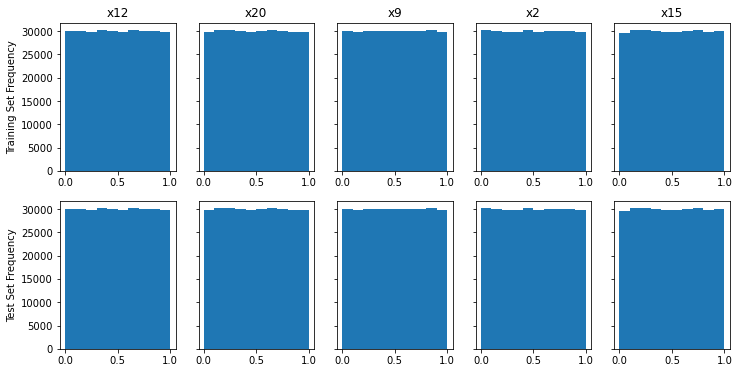

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x12,x20,x9,x2,x15
x12,1.000000,0.000971,0.000827,-0.000555,0.000226
x20,0.000971,1.000000,-0.000187,-0.002474,-0.001044
x9,0.000827,-0.000187,1.000000,0.000247,0.000854
x2,-0.000555,-0.002474,0.000247,1.000000,-0.002513
x15,0.000226,-0.001044,0.000854,-0.002513,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x12,x20,x9,x2,x15
x12,1.000000,-0.005193,-0.001499,0.006487,-0.002612
x20,-0.005193,1.000000,-0.004335,-0.003505,-0.001170
x9,-0.001499,-0.004335,1.000000,-0.005051,0.002979
x2,0.006487,-0.003505,-0.005051,1.000000,-0.001057
x15,-0.002612,-0.001170,0.002979,-0.001057,1.000000


Y0 = 2*x1-1?  False
All tau are 0? True


In [7]:
# Choose 2 samples of simD to test
# Dsamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation D'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simD' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simD' / 'samp{}_test.parquet'.format(samp))

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately uniform...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    feat_list = ['x'+str(x) for x in xfeats]
    
    print('Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(tr.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    print('\nTest Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(te.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    
    # Get potential outcomes
    tr = get_potential_outcomes(tr)
    te = get_potential_outcomes(te)
    
    print('Y0 = 2*x1-1? ', all(np.isclose(tr.y0, 2*tr.x1-1)) & all(np.isclose(te.y0, 2*te.x1-1)))
    
    print('All tau are 0?', (all(tr.tau==0)&all(te.tau==0)))


#### Failed to confirm that Y0 is a linear transformation of x1. All other checks passed.

## Sim E


Testing Sample 1 of Simulation E
Visually check that x18, x4, x13, x3, and x10 are approximately uniform...


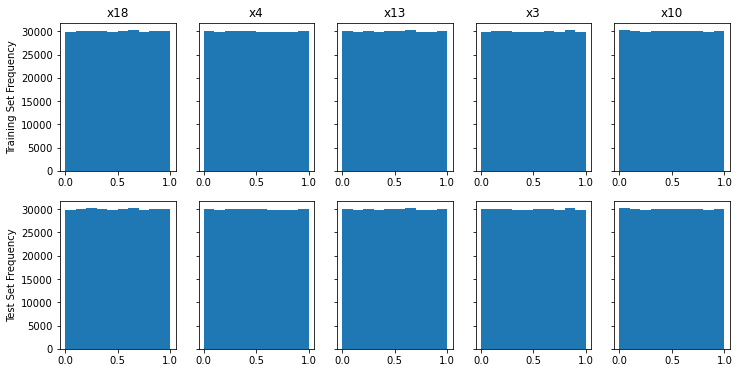

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x18,x4,x13,x3,x10
x18,1.000000,-0.002852,-0.002671,-0.004608,0.001538
x4,-0.002852,1.000000,-0.001901,0.000519,0.003601
x13,-0.002671,-0.001901,1.000000,0.000077,-0.001817
x3,-0.004608,0.000519,0.000077,1.000000,0.000721
x10,0.001538,0.003601,-0.001817,0.000721,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x18,x4,x13,x3,x10
x18,1.000000,0.000429,0.005103,-0.001947,-0.000996
x4,0.000429,1.000000,-0.001485,0.003409,-0.000120
x13,0.005103,-0.001485,1.000000,0.004026,-0.004570
x3,-0.001947,0.003409,0.004026,1.000000,-0.003058
x10,-0.000996,-0.000120,-0.004570,-0.003058,1.000000


Y0 = 2*x1-1?  False
Wherever x2>0.1, tau=8?  True
Wherever x2<=0.1, tau=0?  True

Testing Sample 2 of Simulation E
Visually check that x20, x12, x7, x3, and x2 are approximately uniform...


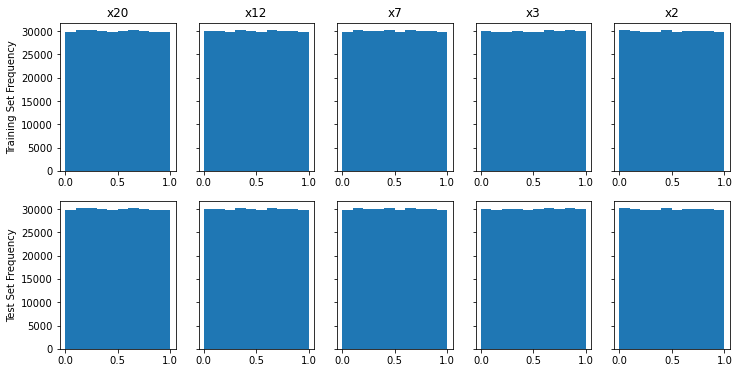

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x20,x12,x7,x3,x2
x20,1.000000,0.000971,-0.000422,0.000744,-0.002474
x12,0.000971,1.000000,-0.000914,0.002637,-0.000555
x7,-0.000422,-0.000914,1.000000,-0.000429,-0.000574
x3,0.000744,0.002637,-0.000429,1.000000,-0.000191
x2,-0.002474,-0.000555,-0.000574,-0.000191,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x20,x12,x7,x3,x2
x20,1.000000,-0.005193,0.000264,0.002237,-0.003505
x12,-0.005193,1.000000,0.005684,0.004287,0.006487
x7,0.000264,0.005684,1.000000,-0.007634,-0.000246
x3,0.002237,0.004287,-0.007634,1.000000,0.003167
x2,-0.003505,0.006487,-0.000246,0.003167,1.000000


Y0 = 2*x1-1?  False
Wherever x2>0.1, tau=8?  True
Wherever x2<=0.1, tau=0?  True


In [8]:
# Choose 2 samples of simE to test
# Esamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation E'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simE' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simE' / 'samp{}_test.parquet'.format(samp))

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately uniform...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    feat_list = ['x'+str(x) for x in xfeats]
    
    print('Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(tr.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    print('\nTest Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(te.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    
    # Get potential outcomes
    tr = get_potential_outcomes(tr)
    te = get_potential_outcomes(te)
    
    print('Y0 = 2*x1-1? ', all(np.isclose(tr.y0, 2*tr.x1-1)) & all(np.isclose(te.y0, 2*te.x1-1)))
    
    
    print('Wherever x2>0.1, tau=8? ', all(np.isclose(tr[tr.x2>0.1]['tau'],8)) \
                                    & all(np.isclose(te[te.x2>0.1]['tau'],8)))
    print('Wherever x2<=0.1, tau=0? ', all(np.isclose(tr[tr.x2<=0.1]['tau'],0)) \
                                    & all(np.isclose(te[te.x2<=0.1]['tau'],0)))


#### Failed to confirm that Y0 is a linear transformation of x1. All other checks passed.

## Sim F


Testing Sample 1 of Simulation F
Visually check that x8, x10, x3, x20, and x4 are approximately uniform...


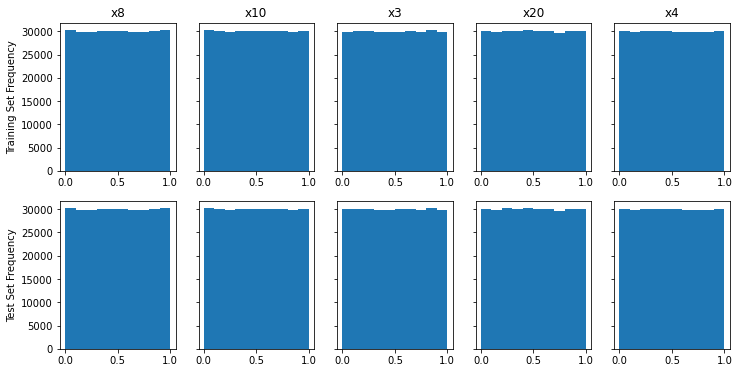

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x8,x10,x3,x20,x4
x8,1.000000,-0.000741,0.002605,0.000541,0.000446
x10,-0.000741,1.000000,0.000721,-0.002675,0.003601
x3,0.002605,0.000721,1.000000,-0.000495,0.000519
x20,0.000541,-0.002675,-0.000495,1.000000,0.000803
x4,0.000446,0.003601,0.000519,0.000803,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x8,x10,x3,x20,x4
x8,1.000000,0.003320,0.000519,-0.004769,-0.000519
x10,0.003320,1.000000,-0.003058,-0.003194,-0.000120
x3,0.000519,-0.003058,1.000000,0.003575,0.003409
x20,-0.004769,-0.003194,0.003575,1.000000,-0.004223
x4,-0.000519,-0.000120,0.003409,-0.004223,1.000000


Y0 = 2*x1-1?  False
Wherever x2>0.1, tau=4*pscore+7?  True
Wherever x2<=0.1, tau=4*pscore-1?  True

Testing Sample 2 of Simulation F
Visually check that x13, x9, x15, x12, and x6 are approximately uniform...


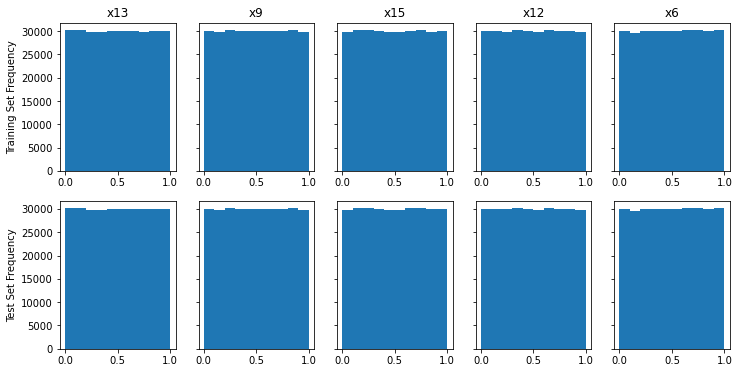

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x13,x9,x15,x12,x6
x13,1.000000,0.001712,0.000693,-0.000127,-0.003482
x9,0.001712,1.000000,0.000854,0.000827,0.001830
x15,0.000693,0.000854,1.000000,0.000226,0.001095
x12,-0.000127,0.000827,0.000226,1.000000,0.001287
x6,-0.003482,0.001830,0.001095,0.001287,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x13,x9,x15,x12,x6
x13,1.000000,0.001976,0.003105,0.006422,-0.000159
x9,0.001976,1.000000,0.002979,-0.001499,-0.001719
x15,0.003105,0.002979,1.000000,-0.002612,0.000866
x12,0.006422,-0.001499,-0.002612,1.000000,0.000145
x6,-0.000159,-0.001719,0.000866,0.000145,1.000000


Y0 = 2*x1-1?  False
Wherever x2>0.1, tau=4*pscore+7?  True
Wherever x2<=0.1, tau=4*pscore-1?  True


In [9]:
# Choose 2 samples of simF to test
# Fsamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation F'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simF' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simF' / 'samp{}_test.parquet'.format(samp))

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately uniform...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    feat_list = ['x'+str(x) for x in xfeats]
    
    print('Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(tr.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    print('\nTest Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(te.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    
    # Get potential outcomes
    tr = get_potential_outcomes(tr)
    te = get_potential_outcomes(te)
    
    print('Y0 = 2*x1-1? ', all(np.isclose(tr.y0, 2*tr.x1-1)) & all(np.isclose(te.y0, 2*te.x1-1)))
    
    
    print('Wherever x2>0.1, tau=4*pscore+7? ', all(np.isclose(tr[tr.x2>0.1]['tau'],\
                                                                 4*tr[tr.x2>0.1]['pscore']+7)) \
                                                 & all(np.isclose(te[te.x2>0.1]['tau'],\
                                                                 4*te[te.x2>0.1]['pscore']+7)))
    print('Wherever x2<=0.1, tau=4*pscore-1? ', all(np.isclose(tr[tr.x2<=0.1]['tau'],\
                                                                 4*tr[tr.x2<=0.1]['pscore']-1)) \
                                                 & all(np.isclose(te[te.x2<=0.1]['tau'],\
                                                                 4*te[te.x2<=0.1]['pscore']-1)))


#### Failed to confirm that Y0 is a linear transformation of x1. All other checks passed.